<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/10_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] hdbscan kneed

In [2]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml, load_iris
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import umap
import umap.plot as uplot

from kneed import KneeLocator

import hdbscan
from hdbscan.validity import validity_index

sns.set_theme()

### Mnist Dataset

In [3]:
mnist = fetch_openml('mnist_784', parser='auto')

digits_data = mnist.data/255 # DataFrame
digit_labels = mnist.target

digit_labels_df = pd.DataFrame(digit_labels)
label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

<ipython-input-3-cd0e7a740970>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000)


Number of PCA components 784


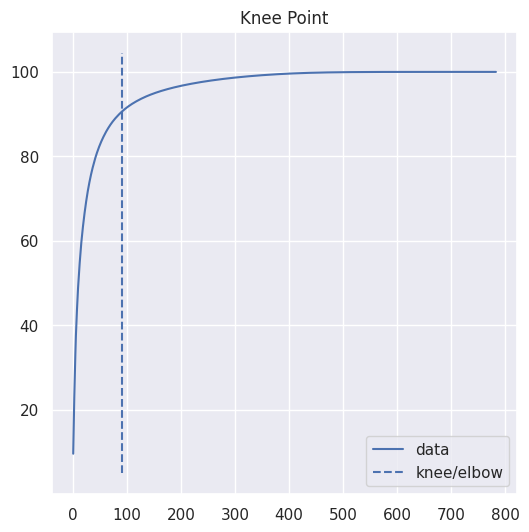

In [4]:
pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()

In [5]:
pca_dim_red = pca_transformed_data[:,:50]

<Axes: >

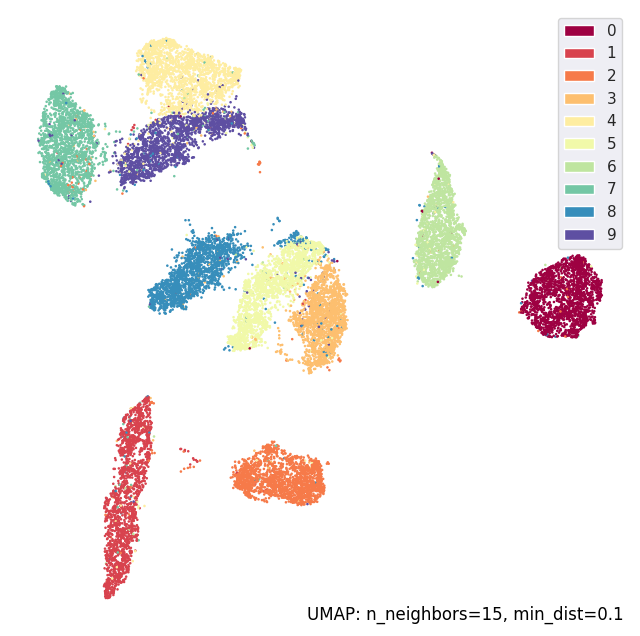

In [6]:
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_dim_red)

uplot.points(umap_obj, labels=digit_labels)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

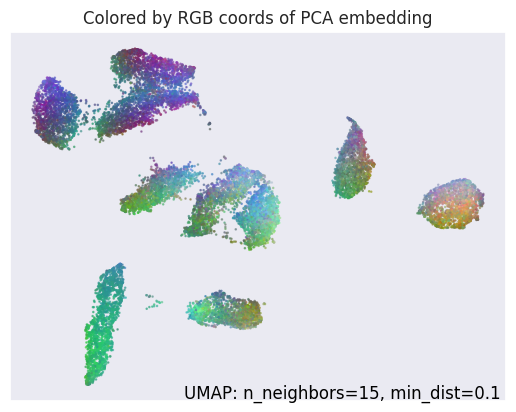

In [7]:
umap.plot.diagnostic(umap_obj, diagnostic_type='pca')

<Axes: >

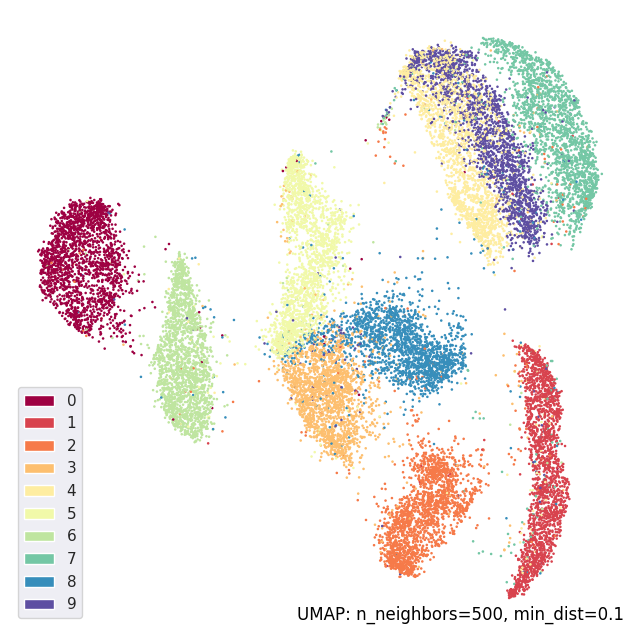

In [8]:
umap_obj2 = umap.UMAP(n_neighbors=500)
embedding = umap_obj2.fit_transform(pca_dim_red)

uplot.points(umap_obj2, labels=digit_labels)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

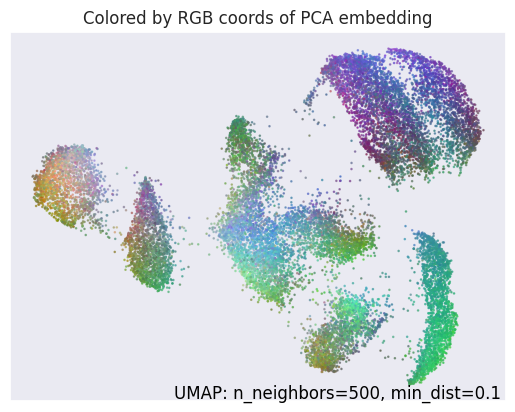

In [9]:
umap.plot.diagnostic(umap_obj2, diagnostic_type='pca')

### HDBSCAN

In [10]:
def print_clustering_stats(clusterer, clust_data, data_labels, dbcv=False):
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    if dbcv == True:
        print('DBCV : {}'.format(validity_index(clust_data, np_labels)))
    unique, counts = np.unique(clusterer.labels_, return_counts=True)
    print(f'cluster counts: {dict(zip(unique, counts))}')

ARI : 0.0620451604091957
ARI sub : 0.9949149740514572
DBCV : 0.0275406710127663
cluster counts: {-1: 14873, 0: 486, 1: 133, 2: 328, 3: 619, 4: 119, 5: 163, 6: 612, 7: 406, 8: 379, 9: 1882}


<Axes: >

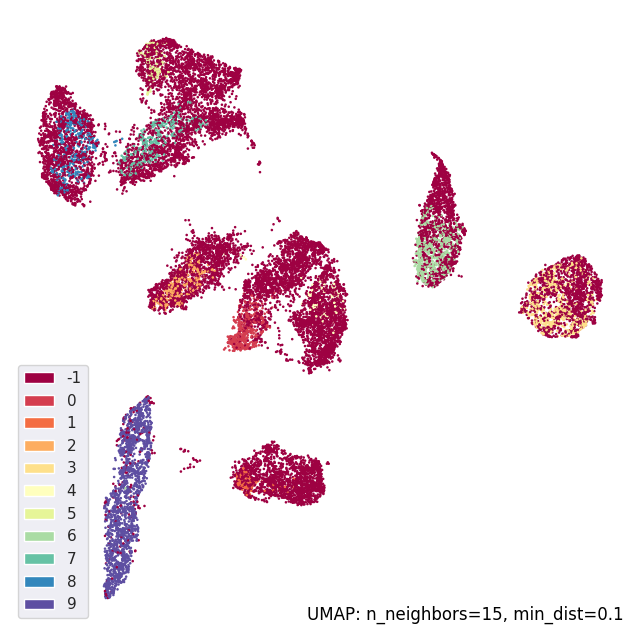

In [11]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    metric='euclidean'
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels,
    dbcv=True
)

uplot.points(umap_obj, labels=clusterer.labels_)

### DBCV

In [12]:
def plot_distances(min_pts):
    knn = NearestNeighbors(n_neighbors=min_pts+1)
    knn.fit(pca_dim_red)
    distances, _ = knn.kneighbors(pca_dim_red)

    distances_min_pts = distances[:, -1]

    distances_by_label = {label: [] for label in np.unique(digit_labels)}
    for i, label in enumerate(digit_labels):
        distances_by_label[label].append(distances_min_pts[i])

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    fig.suptitle(f'min_pts: {min_pts}')
    for label, ax in zip(distances_by_label.keys(), axes.flatten()):
        sort_dist = np.sort(distances_by_label[label])
        ax.plot(range(sort_dist.shape[0]), sort_dist)

        ax.set_title(f'label {label}')
        ax.set_xlabel('index')
        ax.set_ylabel('distance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [13]:
def run_dbcv(eps, min_pts):
    dbscan_tun = DBSCAN(eps=eps, min_samples=min_pts)
    _ = dbscan_tun.fit(pca_dim_red)

    print_clustering_stats(
        clusterer=dbscan_tun,
        clust_data=pca_dim_red,
        data_labels=digit_labels
    )

    uplot.points(umap_obj, labels=dbscan_tun.labels_)
    plt.title(f"eps: {eps}, min_pts: {min_pts}")  # 加入標題
    plt.show()
    return dbscan_tun

In [14]:
def plot_dbcv_point_types(dbscan_tun):
    point_types = np.full(dbscan_tun.labels_.shape, "border point", dtype=object)

    point_types[dbscan_tun.labels_ == -1] = "noise point"
    point_types[dbscan_tun.core_sample_indices_] = "core point"

    uplot.points(umap_obj, labels=point_types)
    plt.title("DBSCAN Core, Border, and Noise Points")
    plt.show()

#### try 1 (min_pts=50, eps=5)

In [15]:
min_pts = 50

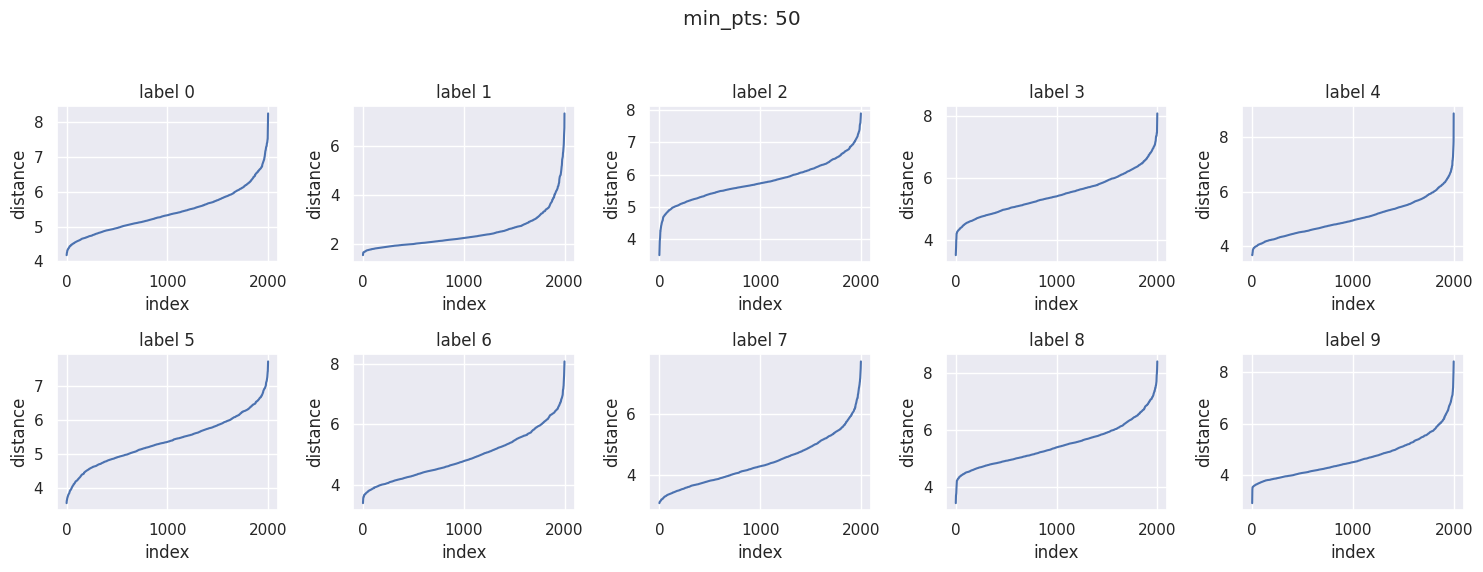

In [16]:
plot_distances(min_pts)

In [17]:
eps = 5

ARI : 0.015190023771268329
ARI sub : 0.0014102175332061382
cluster counts: {-1: 3629, 0: 16276, 1: 95}


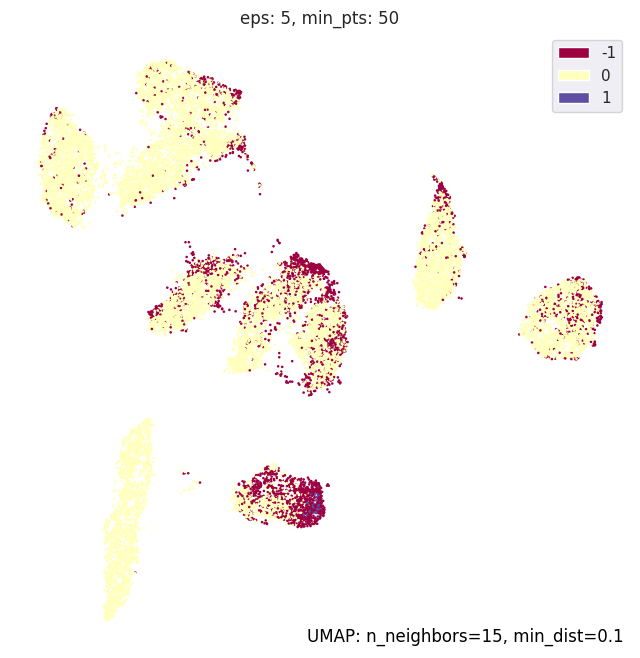

In [18]:
dbscan_tun = run_dbcv(eps, min_pts)

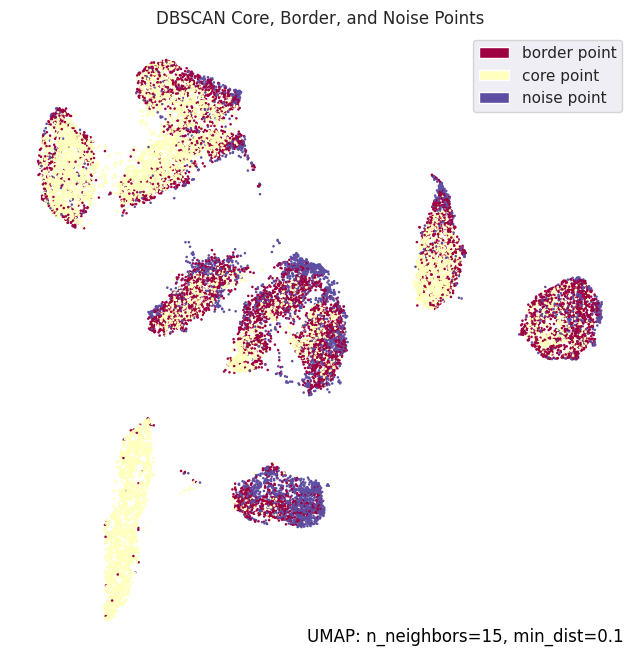

In [19]:
plot_dbcv_point_types(dbscan_tun)

#### try 2 (min_pts=3, eps=4)

In [20]:
min_pts = 3

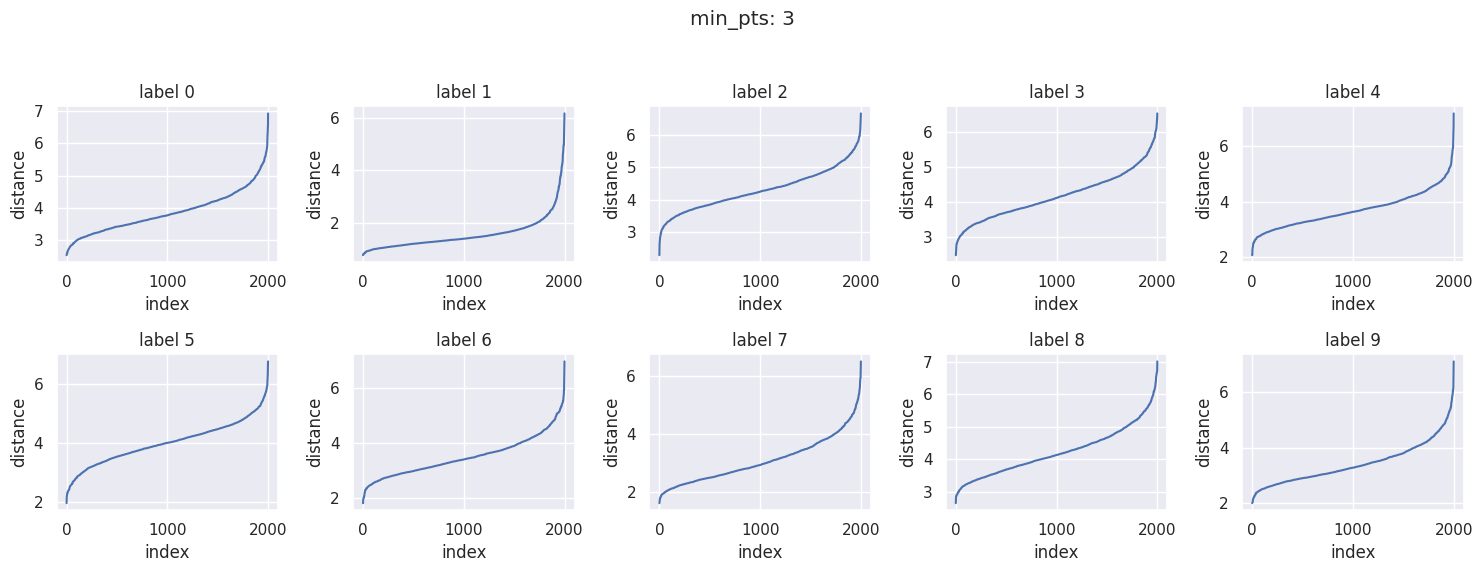

In [21]:
plot_distances(min_pts)

In [22]:
eps = 4

ARI : 0.013010891067727105
ARI sub : 0.0021300817001440723
cluster counts: {-1: 4084, 0: 15459, 1: 7, 2: 4, 3: 5, 4: 3, 5: 3, 6: 5, 7: 3, 8: 4, 9: 6, 10: 6, 11: 3, 12: 3, 13: 3, 14: 5, 15: 4, 16: 6, 17: 4, 18: 4, 19: 6, 20: 3, 21: 3, 22: 4, 23: 4, 24: 3, 25: 5, 26: 6, 27: 4, 28: 3, 29: 4, 30: 3, 31: 4, 32: 3, 33: 9, 34: 4, 35: 3, 36: 3, 37: 5, 38: 4, 39: 4, 40: 3, 41: 3, 42: 3, 43: 3, 44: 3, 45: 4, 46: 3, 47: 5, 48: 6, 49: 5, 50: 4, 51: 3, 52: 4, 53: 6, 54: 5, 55: 4, 56: 3, 57: 3, 58: 3, 59: 9, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 6, 66: 3, 67: 5, 68: 4, 69: 3, 70: 3, 71: 3, 72: 5, 73: 3, 74: 3, 75: 3, 76: 3, 77: 6, 78: 3, 79: 4, 80: 3, 81: 5, 82: 3, 83: 3, 84: 4, 85: 3, 86: 3, 87: 5, 88: 3, 89: 4, 90: 3, 91: 3, 92: 3, 93: 3, 94: 3, 95: 4, 96: 3, 97: 4, 98: 5, 99: 3, 100: 4, 101: 4, 102: 3, 103: 3, 104: 3, 105: 3, 106: 3, 107: 3, 108: 3, 109: 3, 110: 3, 111: 4, 112: 3, 113: 3, 114: 3, 115: 3, 116: 3, 117: 3, 118: 3, 119: 4, 120: 4}


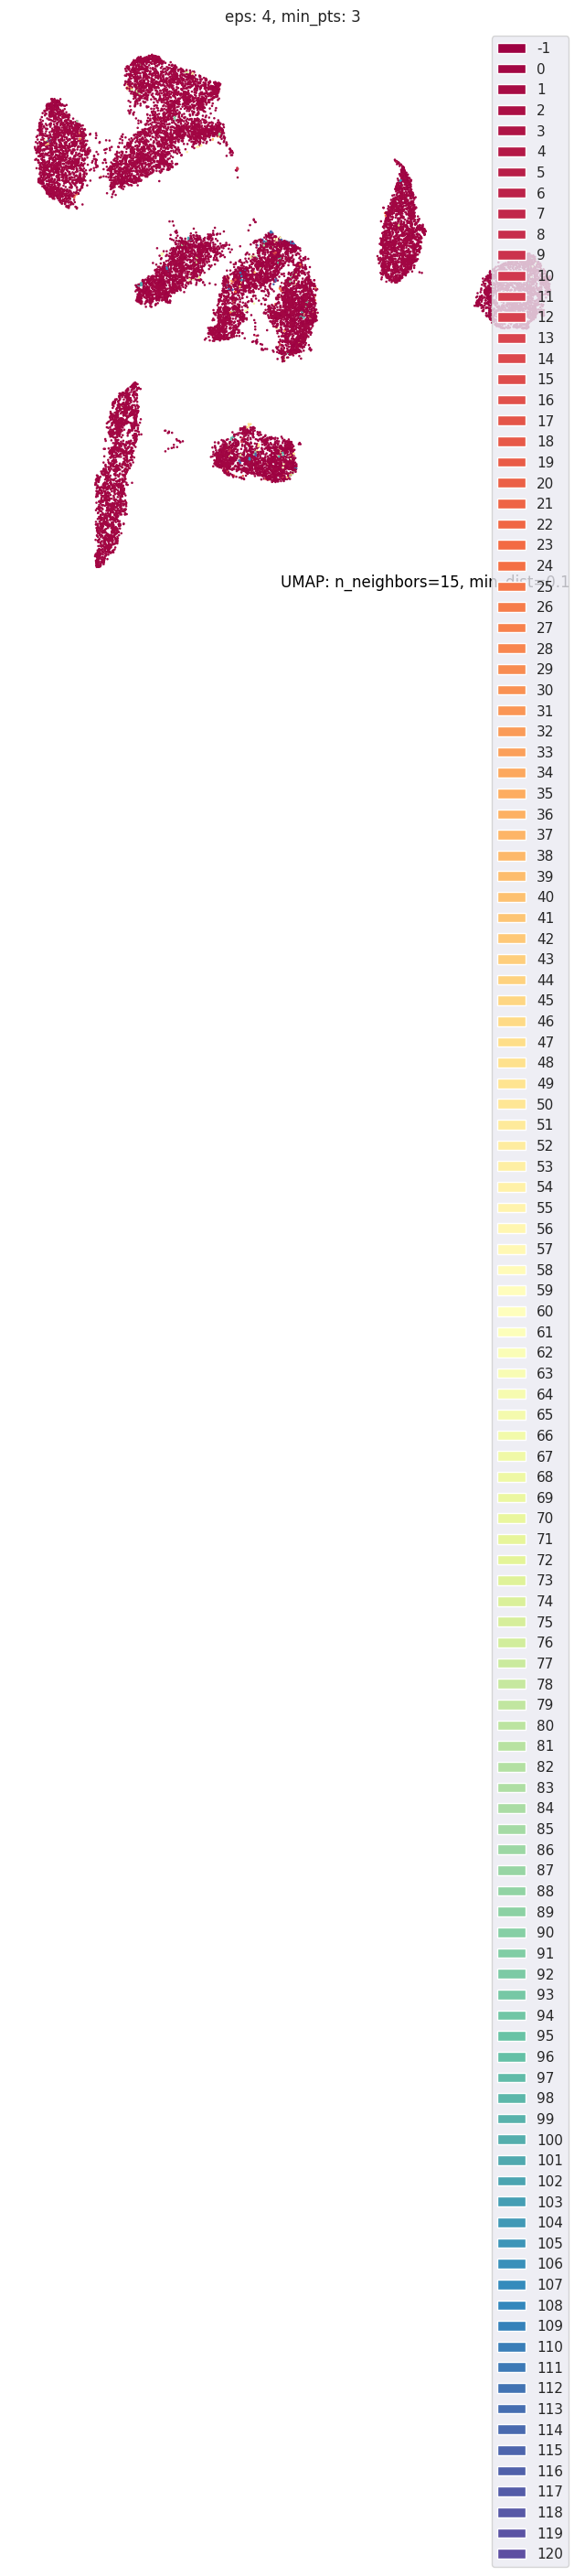

In [23]:
dbscan_tun = run_dbcv(eps, min_pts)

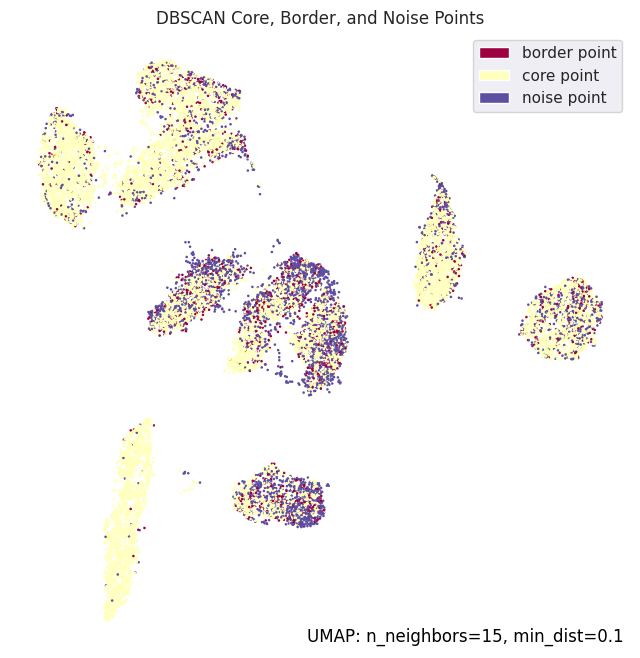

In [24]:
plot_dbcv_point_types(dbscan_tun)

#### try 3 (min_pts=5, eps=3)

In [40]:
min_pts = 5

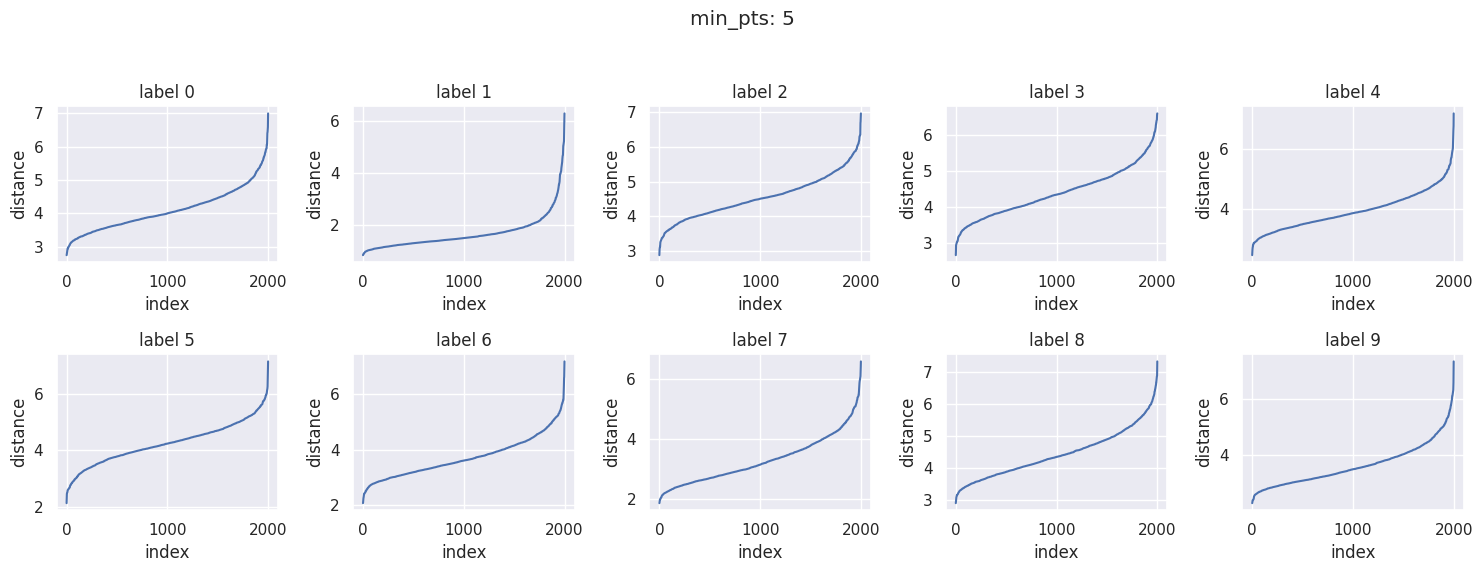

In [41]:
plot_distances(min_pts)

In [42]:
eps = 3

ARI : 0.06906133138891003
ARI sub : 0.15863701822291698
cluster counts: {-1: 14418, 0: 4725, 1: 7, 2: 172, 3: 14, 4: 136, 5: 5, 6: 6, 7: 9, 8: 8, 9: 5, 10: 6, 11: 14, 12: 7, 13: 5, 14: 9, 15: 13, 16: 25, 17: 7, 18: 9, 19: 5, 20: 5, 21: 21, 22: 5, 23: 3, 24: 3, 25: 10, 26: 8, 27: 7, 28: 6, 29: 6, 30: 3, 31: 6, 32: 7, 33: 6, 34: 10, 35: 5, 36: 5, 37: 5, 38: 11, 39: 7, 40: 5, 41: 16, 42: 6, 43: 5, 44: 5, 45: 3, 46: 5, 47: 8, 48: 8, 49: 8, 50: 8, 51: 8, 52: 3, 53: 4, 54: 9, 55: 5, 56: 6, 57: 8, 58: 12, 59: 5, 60: 7, 61: 5, 62: 4, 63: 3, 64: 5, 65: 5, 66: 5, 67: 5, 68: 6, 69: 3, 70: 4, 71: 8, 72: 3, 73: 5, 74: 5, 75: 4, 76: 5, 77: 2, 78: 5, 79: 4, 80: 5, 81: 6, 82: 5, 83: 5, 84: 5}


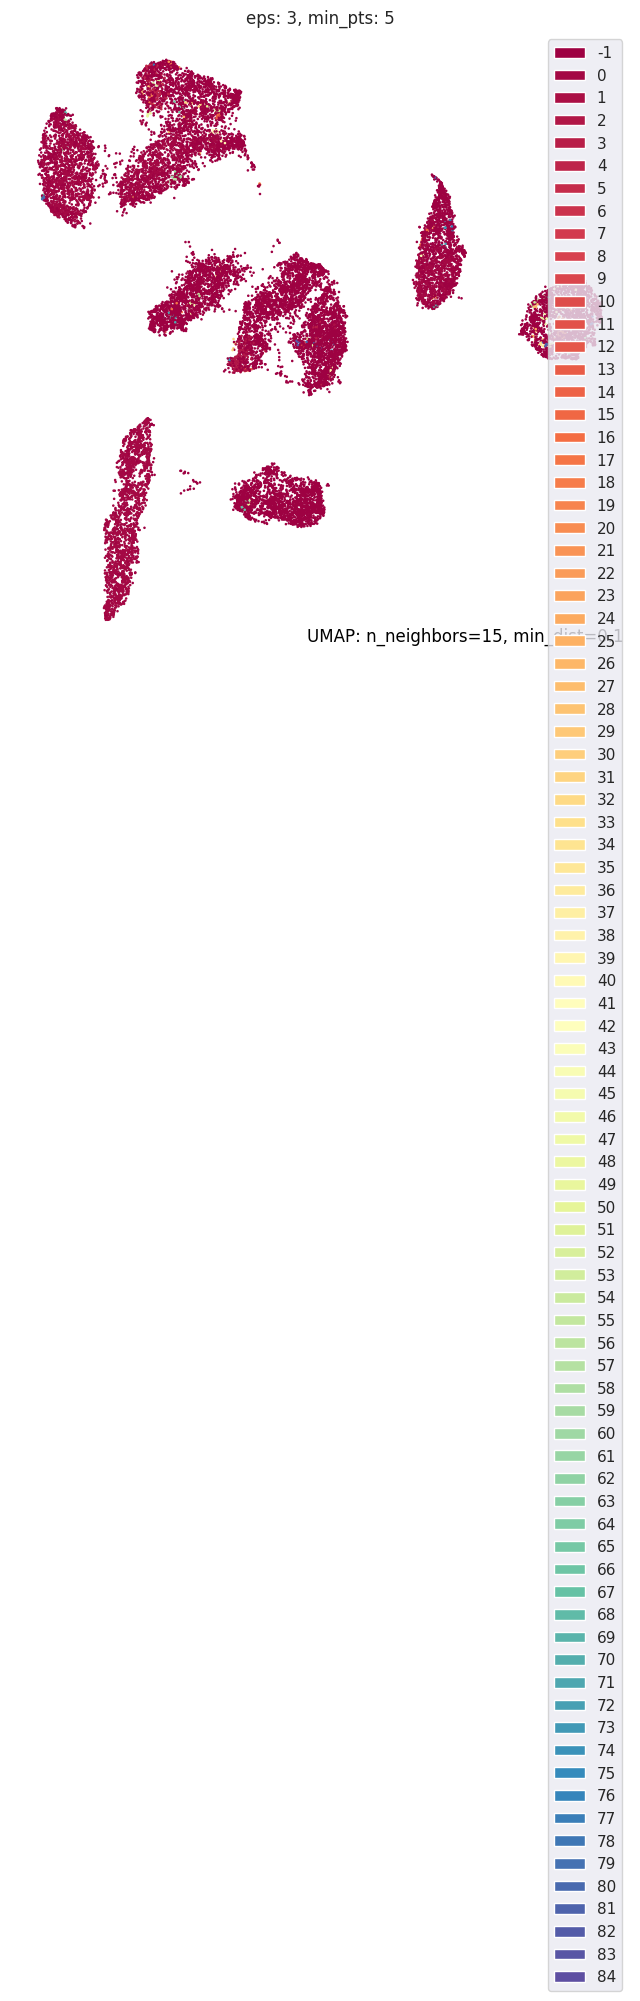

In [43]:
dbscan_tun = run_dbcv(eps, min_pts)

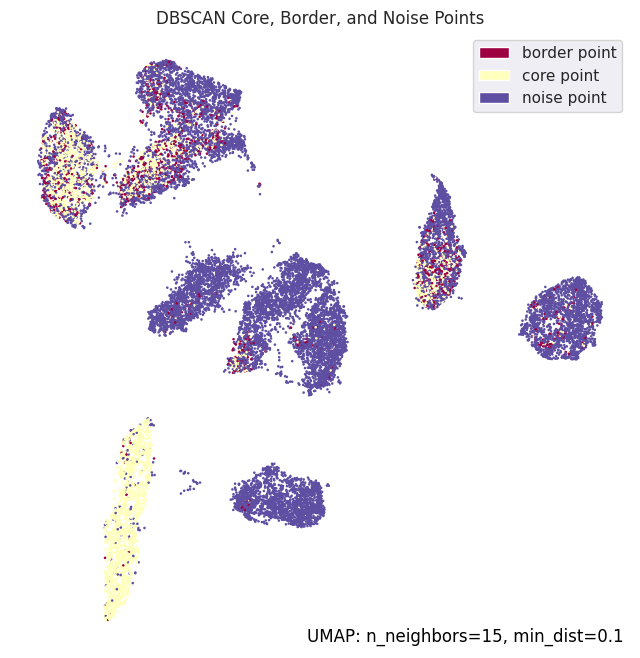

In [44]:
plot_dbcv_point_types(dbscan_tun)